The goal of this notebook is to analyze a subset of sequences from the entire data set. We should look at on values, off values, onoff ratios, species of origin, and motifs in the subset given. This is designed to be general purpose.

In [19]:
# import statements
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from collections import Counter
import scipy.stats as sp
import logomaker as lm
from pysster.One_Hot_Encoder import One_Hot_Encoder

import matplotlib
import matplotlib.font_manager as fm
import os
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

# Part 1: Load in and clean up data for use

In [20]:
# Load in data
data_dir = '../../data/'
file_name = 'newQC_toehold_data.csv'
data_df = pd.read_csv(data_dir + file_name,sep=',')
print(data_df.head(5))

                                              off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   
3  AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...   
4  AACCAAACACACAAACGCACAAAAAAAATGGAAAACAGTTACTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...        smallpox   
4  ACATATTAGTAACTGTTTTCCATTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  

### Filter the data based on QCs, as defined in Angenent-Mari et al.

In [21]:
new_data_df = data_df[~np.isnan(data_df['on_value'])]
new_data_df = new_data_df[~np.isnan(new_data_df['off_value'])]
new_data_df = new_data_df[new_data_df['off_qc'] >= 1.1]
new_data_df = new_data_df[new_data_df['on_qc'] >= 1.1].reset_index()

toehold_seqs = new_data_df['switch_sequence']
seq_len = len(toehold_seqs[0])

print('Number of remaining sequences: ', len(new_data_df))

Number of remaining sequences:  91534


# Part 2: Get subset of sequences of interest

In [22]:
# Extract bottom performing sequences from the experimental data
bottom_sorted_exp = just_pred_seqs_exp.sort_values(by = 'onoff_value')
cutoff = np.percentile(bottom_sorted_exp['onoff_value'], 75) # return 75th percentile and below
print(cutoff)
bottom_sorted_exp = just_pred_seqs_exp[just_pred_seqs_exp['onoff_value'] < cutoff]
print(bottom_sorted_exp.shape)

0.4739866692500001
(68650, 22)


In [23]:
# Extract top performing sequences from the experimental data
sorted_exp = just_pred_seqs_exp.sort_values(by = 'onoff_value')
cutoff = np.percentile(sorted_exp['onoff_value'], 75) # return 75th percentile and above
print(cutoff)
sorted_exp = just_pred_seqs_exp[just_pred_seqs_exp['onoff_value'] > cutoff]
print(sorted_exp.shape)

0.4739866692500001
(22884, 22)


In [24]:
# convert all seqs to RNA instead of DNA
def convert_DNA_to_RNA(one_seq):
    new_str = ''
    for s in one_seq:
        char = ''
        if s == 'A':
            char = 'A'
        elif s == 'T':
            char = 'U'
        elif s == 'C':
            char = 'C'
        elif s == 'G':
            char = 'G'
        else:
            print('UH OH! Character not A, T, C, or G')
        new_str += char
    return new_str

In [25]:
switches = just_pred_seqs_exp.loc[:, 'switch_sequence']
switches = [convert_DNA_to_RNA(x) for x in switches]

subset_switches = sorted_exp.loc[:, 'switch_sequence']
subset_switches = [convert_DNA_to_RNA(x) for x in subset_switches]

bot_subset_switches = bottom_sorted_exp.loc[:, 'switch_sequence']
bot_subset_switches = [convert_DNA_to_RNA(x) for x in bot_subset_switches]

# Part 3: Sequence Logos of Subset vs All

In [26]:
alph_letters = 'AUCG'
alph = list(alph_letters)
print(alph)
# one-hot encode with pysster
one = One_Hot_Encoder(alph_letters)
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    return one_hot_seq

['A', 'U', 'C', 'G']


In [27]:
# get background pwm of all sequences
pfm = np.zeros((30, 4))
for seq in switches:
    pfm = pfm + _get_one_hot_encoding(seq[0:30])
    
counts = pd.DataFrame(pfm)
counts.columns = alph

num_seqs = len(switches)

pwm = lm.transform_matrix(counts, from_type = 'counts', to_type = 'probability')
all_pwm = pwm

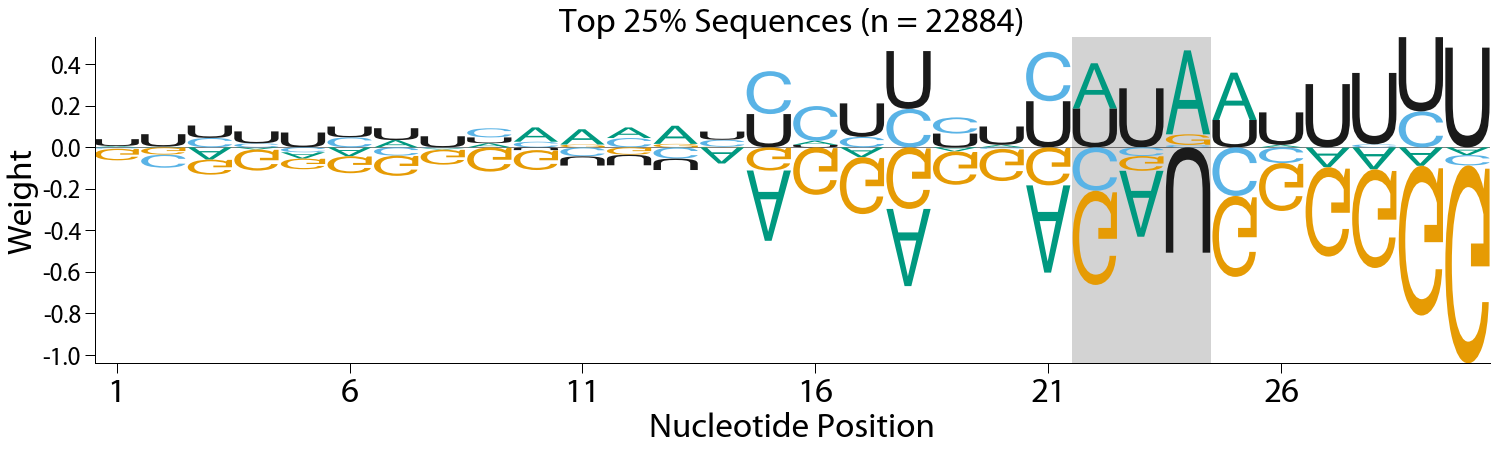

In [28]:
# make top 25% seq logo
fig, ax = plt.subplots(figsize = (25, 6))

pfm = np.zeros((30, 4))

for seq in subset_switches:
    pfm = pfm + _get_one_hot_encoding(seq[0:30])
    
counts = pd.DataFrame(pfm)
counts.columns = alph

num_seqs = len(subset_switches)
pwm = lm.transform_matrix(counts, from_type = 'counts', to_type = 'probability')
pwm = lm.transform_matrix(pwm, from_type = 'probability', to_type = 'weight', background = all_pwm)

logo = lm.Logo(df=pwm,
               font_name='Microsoft Sans Serif', flip_below = True,
               color_scheme = 'colorblind_safe',
               ax = ax, show_spines = False,
               figsize=(30,8)) #  stack_order = 'fixed'

# set axes labels
cap = 'Nucleotide Position'
logo.highlight_position_range(pmin=21, pmax=23, color='lightgray')
logo.ax.set_title('Top 25% Sequences (n = ' + str(num_seqs) + ')', **axis_font, fontsize =35)
logo.ax.set_xlabel(cap, **axis_font, fontsize=35)
logo.ax.set_ylabel("Weight",**axis_font, fontsize=35)
logo.ax.set_yticklabels(labels = [np.round(x, 2) for x in logo.ax.get_yticks()], **axis_font, fontsize=25)
logo.ax.set_xticklabels(labels = [int(x+1) for x in logo.ax.get_xticks()],**axis_font,  fontsize = 35)
logo.ax.tick_params(length = 10, width = 1)
logo.ax.spines['left'].set_visible(True)
logo.ax.spines['bottom'].set_visible(True)

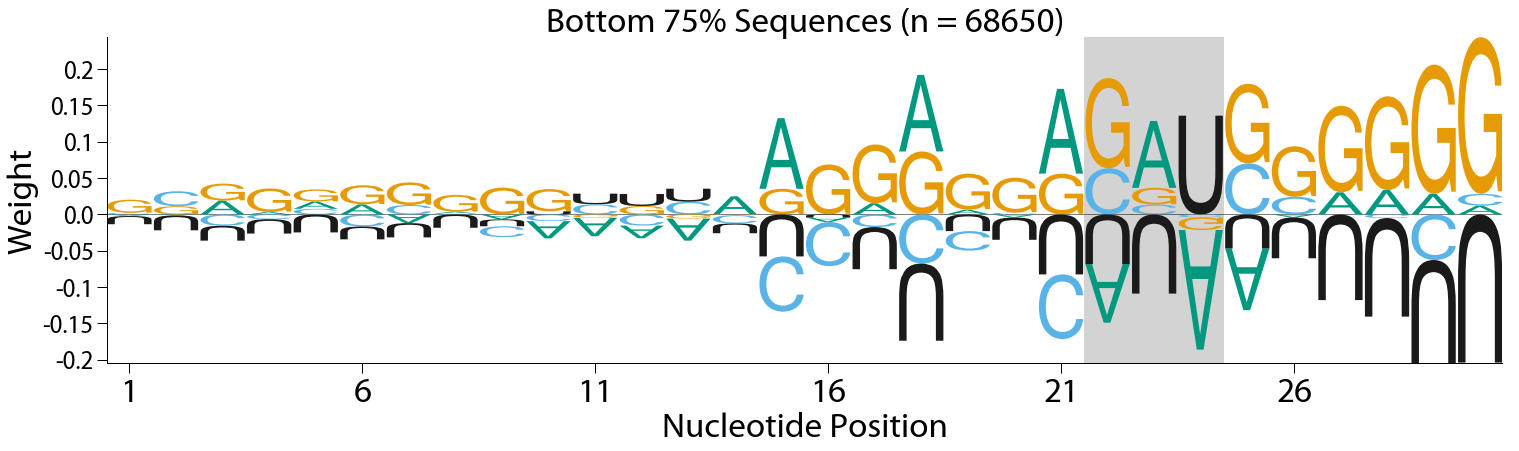

In [29]:
# make bottom 75% seq logo
fig, ax = plt.subplots(figsize = (25, 6))

pfm = np.zeros((30, 4))

for seq in bot_subset_switches:
    pfm = pfm + _get_one_hot_encoding(seq[0:30])
    
counts = pd.DataFrame(pfm)
counts.columns = alph

num_seqs = len(bot_subset_switches)
pwm = lm.transform_matrix(counts, from_type = 'counts', to_type = 'probability')
pwm = lm.transform_matrix(pwm, from_type = 'probability', to_type = 'weight', background = all_pwm)

logo = lm.Logo(df=pwm,
               font_name='Microsoft Sans Serif', flip_below = True, 
            color_scheme = 'colorblind_safe', ax = ax, show_spines = False,
               figsize=(30,8)) # stack_order = 'fixed'

# set axes labels
cap = 'Nucleotide Position'
logo.highlight_position_range(pmin=21, pmax=23, color='lightgrey')
logo.ax.set_title('Bottom 75% Sequences (n = ' + str(num_seqs) + ')', **axis_font, fontsize =35)
logo.ax.set_xlabel(cap,**axis_font, fontsize=35)
logo.ax.set_ylabel("Weight",**axis_font, fontsize=35)
logo.ax.set_yticklabels(labels = [np.round(x, 2) for x in logo.ax.get_yticks()], **axis_font, fontsize=25)
logo.ax.set_xticklabels(labels = [int(x+1) for x in logo.ax.get_xticks()], **axis_font, fontsize = 35)
logo.ax.tick_params(length = 10, width = 1)

logo.ax.spines['left'].set_visible(True)
logo.ax.spines['bottom'].set_visible(True)

In [30]:
# check how many top seqs have UA in positions 22-23 (positions 23-24 when not zero-indexed) 
pos_22_23 = [x[22:24] for x in subset_switches]
true_false = [x == 'UA' for x in pos_22_23]
print(sum(true_false))
print(len(true_false))

2358
22884


In [31]:
# check how many top seqs have U in position 22 (position 23 when not zero-indexed) 
pos_22_U = [x[22] for x in subset_switches]
true_22 = [x == 'U' for x in pos_22_U]
print(sum(true_22))

8833


In [32]:
# check how many top seqs have A in position 23 (position 24 when not zero-indexed) 
pos_23_A = [x[23] for x in subset_switches]
true_23 = [x == 'A' for x in pos_23_A]
print(sum(true_23))

8086
